### Import Libraries


In [48]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
# Venn diagram
from matplotlib_venn import venn3

# Gerard's libraries
from src.uniprot_client import UniprotClient

from scipy import stats
from statsmodels.stats.multitest import multipletests


___
### Config

In [49]:
TRANSLATE_PROTEIN_ID = False

---
### Load the Data

In [50]:
# Load count table
data_src = "./data/processed/2016_Sasha_THP/SI_THP_RAW_proteomics_data_ss.xlsx"

# Load the data
dataM0 = pd.read_excel(data_src, sheet_name="THP_M0", index_col=0) # Index = Accession
dataM1 = pd.read_excel(data_src, sheet_name="THP_M1", index_col=0) # Index = Accession
dataM2 = pd.read_excel(data_src, sheet_name="THP_M2", index_col=0) # Index = Accession

# Keep only these columns
cols = ["Description", "Score", "Coverage", "# Proteins", "# Unique Peptides", "# Peptides", "# PSMs", "126/126 Count", "127/126 Count", "128/126 Count", "129/126 Count", "130/126 Count", "131/126 Count", "126/126 Variability [%]", "127/126 Variability [%]", "128/126 Variability [%]", "129/126 Variability [%]", "130/126 Variability [%]", "131/126 Variability [%]", "126/126", "127/126", "128/126", "129/126", "130/126", "131/126"]
dataM0 = dataM0[cols]
dataM1 = dataM1[cols]
dataM2 = dataM2[cols]


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Matrix format

* **Accession:** This is a unique identifier assigned to a protein, often from databases like UniProt or RefSeq.
* **Description:** A brief description of the protein's function or characteristics.
* **Score:** A numerical value representing the confidence level of the protein identification. Higher scores indicate more reliable identifications.
* **Coverage:** The percentage of the protein's amino acid sequence that has been covered by identified peptides.
* **#Proteins:** The number of proteins associated with the identified peptides.
* **#Unique Peptides:** The number of distinct peptide sequences identified.
* **#Peptides:** The total number of peptides identified, including duplicates.
* **#PSMs:** The number of Peptide Spectrum Matches, which represent the number of times a peptide sequence has been identified in the mass spectra.
* **126/126 Count:** Counts at moment 0hr
* **127/126 Count:** Counts at moment 8hr
* **128/126 Count:** Counts at moment 12hr
* **129/126 Count:** Counts at moment 24hr
* **130/126 Count:** Counts at moment 48hr
* **131/126 Count:** Counts at moment 72hr

Additional information: https://www.biotech.iastate.edu/wp_biotech/wp-content/uploads/2023/07/ProteomeDiscovererInstructions.pdf


### Cell types

* **M0** - Undifferentiated macrophages or monocytes
* **M1** - Classically activated macrophages (LPS or IFN-γ)
* **M2** - Alternatively activated macrophages (IL-4 or IL-13) 

In [51]:
uniprot = UniprotClient()

def get_genes_from_proteins(data):
    return uniprot.batch_translate_protein_ids(data.index)


In [52]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    print("Translating protein IDs to gene names (dataM0)... ")
    # Get the gene names (the protein names are the index)
    gene_names = unipcl.batch_translate_protein_ids(dataM0.index)
    # Add the gene names to the data as another column
    dataM0['Gene'] = gene_names
    
    print("Translating protein IDs to gene names (dataM1)... ")
    # Get the gene names (the protein names are the index)
    gene_names = unipcl.batch_translate_protein_ids(dataM1.index)
    # Add the gene names to the data as another column
    dataM1['Gene'] = gene_names

    print("Translating protein IDs to gene names (dataM2)... ")
    # Get the gene names (the protein names are the index)
    gene_names = unipcl.batch_translate_protein_ids(dataM2.index)
    # Add the gene names to the data as another column
    dataM2['Gene'] = gene_names


In [53]:
PSM_THRESHOLD = 0
SCORE_THRESHOLD = 0
PEPTIDE_THRESHOLD = 2

# Print the number of proteins in each dataset
print("Filtering out proteins with less than ", PSM_THRESHOLD," PSMs")
print("Initial number of proteins in each dataset:")
print("M0 -", dataM0.shape[0])
print("M1 -", dataM1.shape[0])
print("M2 -", dataM2.shape[0])
print("...")

# Filter out bad quality proteins (by PSMs and score)
dataM0 = dataM0[dataM0["# PSMs"] >= PSM_THRESHOLD]
dataM0 = dataM0[dataM0["Score"] >= SCORE_THRESHOLD]
dataM0 = dataM0[dataM0["# Peptides"] >= PEPTIDE_THRESHOLD]

dataM1 = dataM1[dataM1["# PSMs"] >= PSM_THRESHOLD]
dataM1 = dataM1[dataM1["Score"] >= SCORE_THRESHOLD]
dataM1 = dataM1[dataM1["# Peptides"] >= PEPTIDE_THRESHOLD]

dataM2 = dataM2[dataM2["# PSMs"] >= PSM_THRESHOLD]
dataM2 = dataM2[dataM2["Score"] >= SCORE_THRESHOLD]
dataM2 = dataM2[dataM2["# Peptides"] >= PEPTIDE_THRESHOLD]



# After filtering, print the number of proteins in each dataset
print("After filtering:")
print("M0 -", dataM0.shape[0])
print("M1 -", dataM1.shape[0])
print("M2 -", dataM2.shape[0])



Filtering out proteins with less than  0  PSMs
Initial number of proteins in each dataset:
M0 - 6338
M1 - 6187
M2 - 6722
...
After filtering:
M0 - 4991
M1 - 4895
M2 - 5348


In [54]:
# Merge the three datasets
data = pd.concat([dataM0, dataM1, dataM2], keys=["M0", "M1", "M2"], names=["Type"])
data = data.reset_index(level=0).rename(columns={"level_0": "Type"})

# Save the data
#data.to_csv("./data/processed/2016_Sasha_THP/THP_proteomics_data_merged.csv")


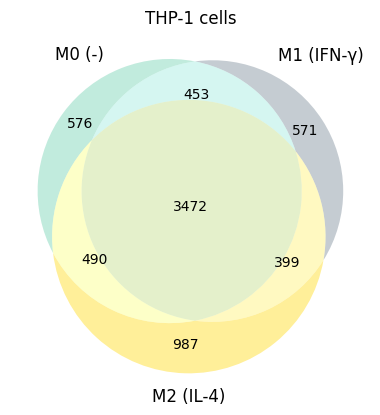

In [55]:
# Venn diagram
proteinsM0 = set(dataM0.index)
proteinsM1 = set(dataM1.index)
proteinsM2 = set(dataM2.index)

venn3([proteinsM0, proteinsM1, proteinsM2], set_labels = ('M0 (-)', 'M1 (IFN-γ)', 'M2 (IL-4)'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.title("THP-1 cells")
plt.show()



### Consider proteins present in the 3 states

In [56]:
# Filter out those not present in all datasets
common_proteins = proteinsM0.intersection(proteinsM1).intersection(proteinsM2)

dataM0 = dataM0.loc[dataM0.index.isin(common_proteins)]
dataM1 = dataM1.loc[dataM1.index.isin(common_proteins)]
dataM2 = dataM2.loc[dataM2.index.isin(common_proteins)]


### Diferential expressed proteins in the different time points
126/126 Count is point 0 in time<br>
127/126 Count is 8 hours point in time<br>
128/126 Count is 12 hours point in time<br>
129/126 Count is 24 hours point in time<br>
130/126 Count is 48 hours point in time<br>
131/126 Count is 72 hours point in time<br>

/var/folders/nb/8pkj_syd5t57qn6g_bqjjp440000gn/T/ipykernel_51311/3895548949.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


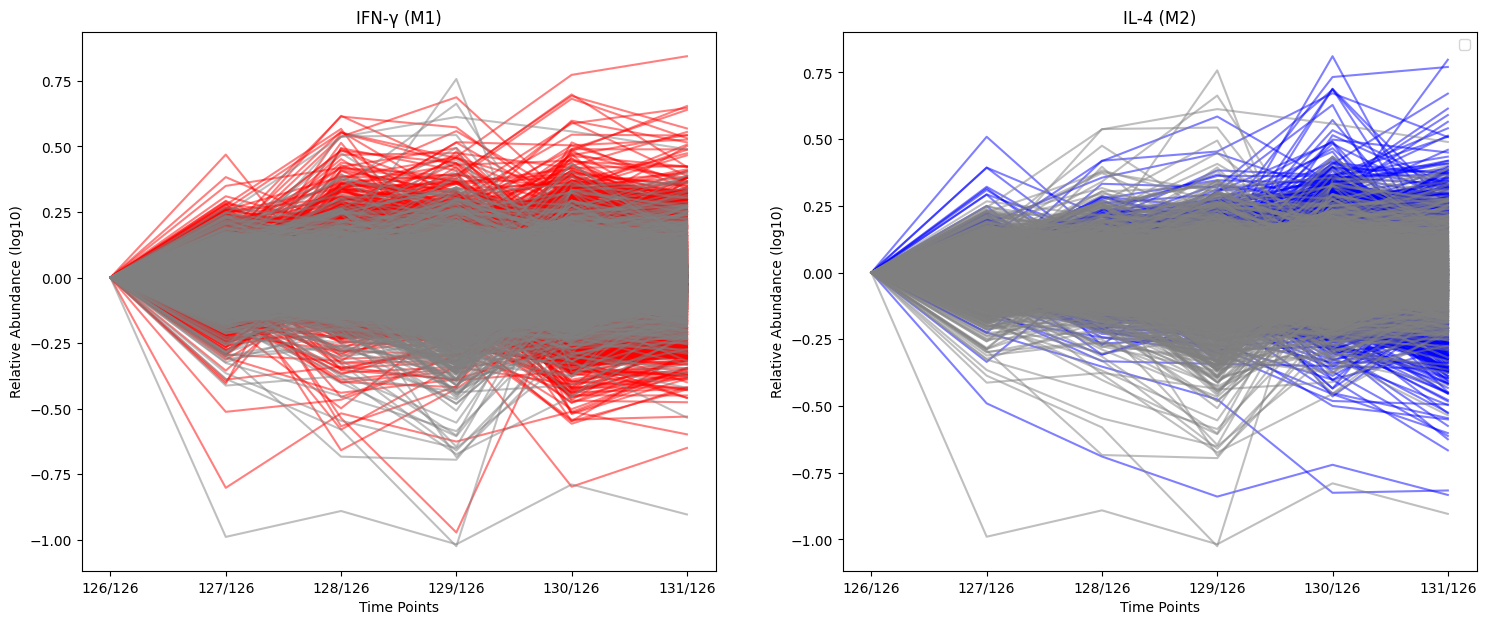

In [57]:
time_points = ["126/126", "127/126", "128/126", "129/126", "130/126", "131/126"]

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# Plot each protein in dataM1 with red lines
for index, row in dataM1.iterrows():
    # Handle zeros to avoid log10(0) error
    values = row[time_points]
    values = [np.log10(v) if v > 0 else np.nan for v in values]
    axs[0].plot(time_points, values, color='red', alpha=0.5)

for index, row in dataM0.iterrows():
    # Handle zeros to avoid log10(0) error
    values = row[time_points]
    values = [np.log10(v) if v > 0 else np.nan for v in values]
    axs[0].plot(time_points, values, color='grey', alpha=0.5)

# Plot each protein in dataM1 with red lines
for index, row in dataM2.iterrows():
    # Handle zeros to avoid log10(0) error
    values = row[time_points]
    values = [np.log10(v) if v > 0 else np.nan for v in values]
    axs[1].plot(time_points, values, color='blue', alpha=0.5)

for index, row in dataM0.iterrows():
    # Handle zeros to avoid log10(0) error
    values = row[time_points]
    values = [np.log10(v) if v > 0 else np.nan for v in values]
    axs[1].plot(time_points, values, color='grey', alpha=0.5)

# Add labels and title
axs[0].set_xlabel("Time Points")
axs[0].set_ylabel("Relative Abundance (log10)")
axs[0].set_title("IFN-γ (M1)")

axs[1].set_xlabel("Time Points")
axs[1].set_ylabel("Relative Abundance (log10)")
axs[1].set_title("IL-4 (M2)")

# Display a legend for M1 and M2 groups
plt.legend()
plt.show()



In [58]:
# Take the proteins with higher variance between M1 and M2
# Calculate the variance for each protein at point 131/126
#dataM1["VarianceVsM2"] = dataM1["131/126"] - dataM2["131/126"]
dataM1["VarianceVsM2"] = np.log10(dataM1["129/126"]) - np.log10(dataM2["129/126"])
dataM1["VarianceVsM2"] = dataM1["VarianceVsM2"]

# Sort the proteins by variance
dataM1 = dataM1.sort_values(by="VarianceVsM2", ascending=False)

# Take the top 10 proteins
top_proteins = dataM1.head(12)

# Print the top proteins
print("Top proteins with higher variance between M1 and M2")
print(top_proteins.index)
print(top_proteins["VarianceVsM2"])




Top proteins with higher variance between M1 and M2
Index(['O14879', 'F8W8T1', 'D3DR31', 'Q9BQE5', 'P42224-2', 'Q03013', 'G3V2M6',
       'F5H648', 'Q00839-2', 'P32456', 'P01584', 'Q8TB52'],
      dtype='object', name='Accession')
Accession
O14879      0.767870
F8W8T1      0.726375
D3DR31      0.688297
Q9BQE5      0.669000
P42224-2    0.595214
Q03013      0.582339
G3V2M6      0.566260
F5H648      0.554417
Q00839-2    0.534461
P32456      0.525790
P01584      0.517857
Q8TB52      0.507618
Name: VarianceVsM2, dtype: float64


In [59]:
print(top_proteins.index)
top_proteins["gene"] = get_genes_from_proteins(top_proteins)
print(top_proteins["gene"])


Index(['O14879', 'F8W8T1', 'D3DR31', 'Q9BQE5', 'P42224-2', 'Q03013', 'G3V2M6',
       'F5H648', 'Q00839-2', 'P32456', 'P01584', 'Q8TB52'],
      dtype='object', name='Accession')
Accession
O14879              IFIT3
F8W8T1                MX1
D3DR31              IFIT1
Q9BQE5              APOL2
P42224-2            STAT1
Q03013              GSTM4
G3V2M6              STAT2
F5H648      None (F5H648)
Q00839-2           HNRNPU
P32456               GBP2
P01584               IL1B
Q8TB52             FBXO30
Name: gene, dtype: object


/var/folders/nb/8pkj_syd5t57qn6g_bqjjp440000gn/T/ipykernel_51311/1919985528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_proteins["gene"] = get_genes_from_proteins(top_proteins)


/var/folders/nb/8pkj_syd5t57qn6g_bqjjp440000gn/T/ipykernel_51311/1972951126.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


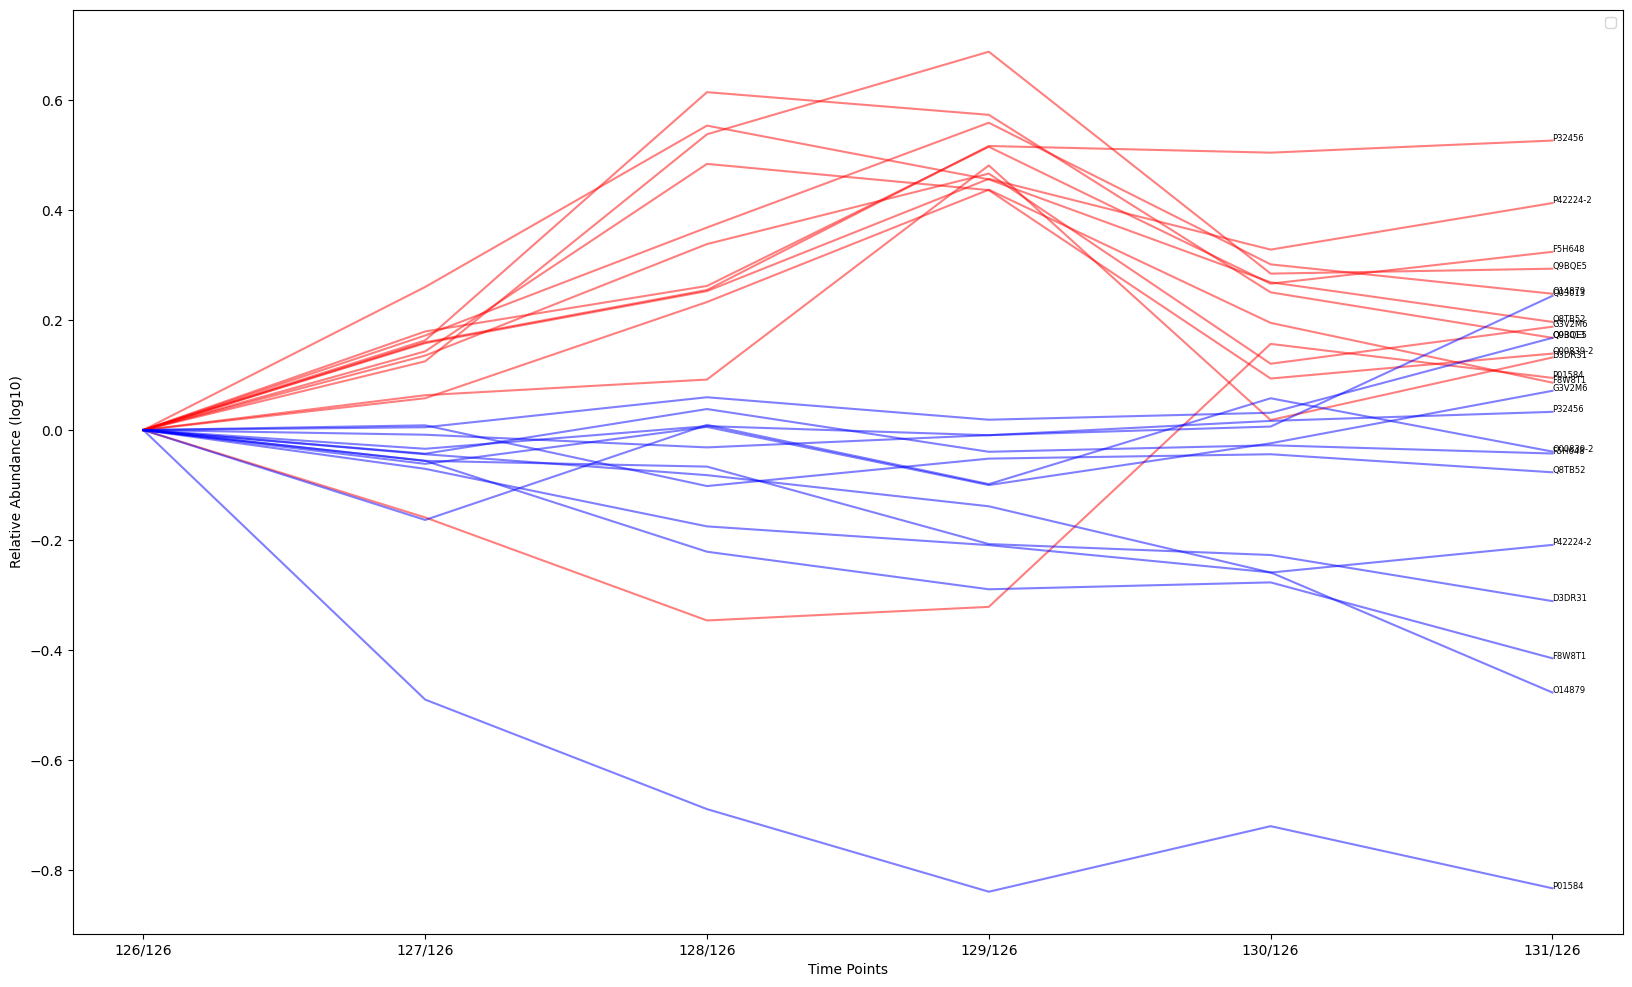

In [60]:
# Plot top proteins
plt.figure(figsize=(20, 12))

# Plot proteins in dataM1 within top_proteins with blue lines
for index, row in dataM1.iterrows():
    if index in top_proteins.index:
        # Handle zeros to avoid log10(0) error
        values = row[time_points]
        values = [np.log10(v) if v > 0 else np.nan for v in values]
        plt.plot(time_points, values, color='red', alpha=0.5, label='M1' if index == 0 else "")
        # Display the name of the proteins in each line
        plt.text(5, values[-1], index, fontsize=6)

for index, row in dataM2.iterrows():
    if index in top_proteins.index:
        # Handle zeros to avoid log10(0) error
        values = row[time_points]
        values = [np.log10(v) if v > 0 else np.nan for v in values]
        plt.plot(time_points, values, color='blue', alpha=0.5, label='M2' if index == 0 else "")
        # Display the name of the proteins in each line
        plt.text(5, values[-1], index, fontsize=6)

"""
    for index, row in dataM0.iterrows():
    if index in top_proteins.index:
        # Handle zeros to avoid log10(0) error
        values = row[time_points]
        values = [np.log10(v) if v > 0 else np.nan for v in values]
        plt.plot(time_points, values, color='grey', alpha=0.5, label='M0' if index == 0 else "")
        # Display the name of the proteins in each line
        plt.text(5, values [-1], index, fontsize=6)
"""


# Add labels and title
plt.xlabel("Time Points")
plt.ylabel("Relative Abundance (log10)")



# Display a legend for M1 and M2 groups
plt.legend()
plt.show()


In [61]:
# Assuming your dataframes are named dataM0, dataM1, and dataM2
# Each dataframe has columns for protein ID, time point, and relative abundance

# Merge dataframes
merged_df = pd.concat([dataM1, dataM2], keys=["M1", "M2"], names=["Type"])
#merged_df = pd.concat([dataM0, dataM1, dataM2], keys=["M0", "M1", "M2"], names=["Type"])
merged_df = merged_df.reset_index(level=0).rename(columns={"level_0": "Type"})

# Pivot the data to have time points as columns and protein IDs as rows
merged_df = merged_df.pivot_table(index='Accession', columns='Type', values=['126/126', '127/126', '128/126', '129/126', '130/126', '131/126'])

KeyError: 'gene'

In [ ]:


# Describe merged_df to see the structure
print(merged_df.head())

          126/126        127/126             128/126             129/126  \
Type           M1   M2        M1        M2        M1        M2        M1   
Accession                                                                  
A0AVT1        1.0  1.0  0.989894  0.936786  0.993734  1.027837  1.038208   
A0FGR8-2      1.0  1.0  0.814161  0.951382  0.797786  0.979001  0.827037   
A0JNW5        1.0  1.0  1.173734  1.045258  0.815727  1.068628  0.795561   
A0MZ66        1.0  1.0  1.042447  1.030733  1.021652  1.040322  1.057116   
A0T124        1.0  1.0  1.315904  0.999784  0.845168  0.846787  0.930313   

                      130/126             131/126            
Type             M2        M1        M2        M1        M2  
Accession                                                    
A0AVT1     0.930783  1.155019  0.918391  1.062646  1.111090  
A0FGR8-2   0.907572  0.687835  0.763631  0.688810  0.739199  
A0JNW5     1.105362  1.232949  0.777797  0.812077  0.801827  
A0MZ66     1.143847

In [ ]:


# drop p_value and adjusted_pvalue columns if they exist
if 'p_value' in merged_df.columns:
    merged_df = merged_df.drop(columns=['p_value'])

if 'adjusted_p_value' in merged_df.columns:
    merged_df = merged_df.drop(columns=['adjusted_p_value'])

# Define IndexSlice shorthand for easier indexing
idx = pd.IndexSlice

# Function to perform paired t-test for each protein
def perform_ttest(row):
    p_values = []
    # Iterate through each unique time point
    for time_point in row.index.get_level_values(0).unique():
        try:
            # Retrieve values for each state (M1, M2) at a given time point
            m1_value = row[(time_point, 'M1')]
            m2_value = row[(time_point, 'M2')]

            # Perform paired t-test and append p-value
            # Here we compare the single values for each time point (assuming scalar values)
            p_value = stats.ttest_rel([m1_value], [m2_value]).pvalue
            
            p_values.append(p_value)
        except KeyError as e:
            print(f"KeyError: {e} at time_point: {time_point}")
    
    # Return a list of p-values for this protein
    return p_values


def perform_diff(row):
    diff_values = []
    # Iterate through each unique time point
    for time_point in row.index.get_level_values(0).unique():
        try:
            # Retrieve values for each state (M1, M2) at a given time point
            m1_value = row[(time_point, 'M1')]
            m2_value = row[(time_point, 'M2')]

            # Perform paired t-test and append p-value
            # Here we compare the single values for each time point (assuming scalar values)
            diff_value = m1_value - m2_value
            
            diff_values.append(diff_value)
        except KeyError as e:
            print(f"KeyError: {e} at time_point: {time_point}")
    
    # Return a list of p-values for this protein
    return diff_values

"""
# Apply the function to each row (protein)
merged_df['p_value'] = merged_df.apply(perform_ttest, axis=1)

# Adjust p-values for multiple testing using Bonferroni correction
# Flatten list of p-values for multiple testing correction across all proteins
flat_p_values = [p for sublist in merged_df['p_value'] for p in sublist]
adjusted_p_values = multipletests(flat_p_values, alpha=0.05, method='bonferroni')[1]

# Add adjusted p-values back to the DataFrame
merged_df['adjusted_p_value'] = [adjusted_p_values[i:i + len(row)] for i, row in enumerate(merged_df['p_value'])]

print(merged_df.head())

# Filter for significant proteins based on adjusted p-values
significant_proteins = merged_df[merged_df['adjusted_p_value'].apply(lambda x: any(val < 0.05 for val in x))]

"""

merged_df['diff_abundance'] = merged_df.apply(perform_diff, axis=1)
print(merged_df.head())



          126/126        127/126             128/126             129/126  \
Type           M1   M2        M1        M2        M1        M2        M1   
Accession                                                                  
A0AVT1        1.0  1.0  0.989894  0.936786  0.993734  1.027837  1.038208   
A0FGR8-2      1.0  1.0  0.814161  0.951382  0.797786  0.979001  0.827037   
A0JNW5        1.0  1.0  1.173734  1.045258  0.815727  1.068628  0.795561   
A0MZ66        1.0  1.0  1.042447  1.030733  1.021652  1.040322  1.057116   
A0T124        1.0  1.0  1.315904  0.999784  0.845168  0.846787  0.930313   

                      130/126             131/126            \
Type             M2        M1        M2        M1        M2   
Accession                                                     
A0AVT1     0.930783  1.155019  0.918391  1.062646  1.111090   
A0FGR8-2   0.907572  0.687835  0.763631  0.688810  0.739199   
A0JNW5     1.105362  1.232949  0.777797  0.812077  0.801827   
A0MZ66     1.

In [ ]:
# Use dff_abundance to filter out those proteins with high increase or decrease between the first two time points
merged_df['diff_abundance'] = merged_df['diff_abundance'].apply(lambda x: x[0])

# Filter out those proteins with high increase or decrease between the first two time points
significant_proteins = merged_df[abs(merged_df['diff_abundance']) > 0.5]

print(significant_proteins.head())


Empty DataFrame
Columns: [(126/126, M1), (126/126, M2), (127/126, M1), (127/126, M2), (128/126, M1), (128/126, M2), (129/126, M1), (129/126, M2), (130/126, M1), (130/126, M2), (131/126, M1), (131/126, M2), (diff_abundance, )]
Index: []


In [ ]:
print(merged_df.head())

          126/126        127/126             128/126             129/126  \
Type           M1   M2        M1        M2        M1        M2        M1   
Accession                                                                  
A0AVT1        1.0  1.0  0.989894  0.936786  0.993734  1.027837  1.038208   
A0FGR8-2      1.0  1.0  0.814161  0.951382  0.797786  0.979001  0.827037   
A0JNW5        1.0  1.0  1.173734  1.045258  0.815727  1.068628  0.795561   
A0MZ66        1.0  1.0  1.042447  1.030733  1.021652  1.040322  1.057116   
A0T124        1.0  1.0  1.315904  0.999784  0.845168  0.846787  0.930313   

                      130/126             131/126           diff_abundance  
Type             M2        M1        M2        M1        M2                 
Accession                                                                   
A0AVT1     0.930783  1.155019  0.918391  1.062646  1.111090            0.0  
A0FGR8-2   0.907572  0.687835  0.763631  0.688810  0.739199            0.0  
A0JNW5

# Functional Enrichment

In [75]:
import gseapy as gp

# Prepare Data for GSEA
de_proteins = ["STAT1", "DTX3L", "PARP14", "SAMD9L", "PARP9", "IFIT3", "CUTA", "PEBP1", "C12orf35", "FBXO30", "CCDC149", "OAS1"]
#de_proteins = top_proteins["gene"].tolist()

#ranked_list = de_proteins.set_index('protein_ID')['rank'].to_dict()

# Run GSEA
enr_res = gp.enrichr(gene_list=de_proteins,
                    gene_sets='KEGG_2021_Human',
                    organism='Human')

**Interpreting the results**

* **Gene Set**: The specific KEGG pathway.
* **Term Overlap**: The number of genes from your DEG list that are also in the KEGG pathway.
* **P-value**: The statistical significance of the overlap. A lower p-value indicates a higher likelihood that the overlap is not due to chance.
* **Adjusted P-value**: This corrects for multiple hypothesis testing, making it a more stringent measure of significance.
* **Odds Ratio**: A measure of the strength of the association between your DEG list and the KEGG pathway.
* **Combined Score**: This is a composite score that takes into account the number of overlapping genes and their ranking within your DEG list. A higher score indicates a stronger enrichment.
* **Genes**: The specific genes from your DEG list that are present in the KEGG pathway.

<br>

**Relevance of the Pathways**

To determine the relevance of a particular pathway, we must consider the following:

* **Biological Context**: Does the pathway align with your biological hypothesis or the known function of the genes in your study?
* **P-value and Adjusted P-value**: A lower p-value indicates a higher level of significance.
* **Combined Score**: A higher combined score suggests a stronger enrichment.
* **Overlapping Genes**: The specific genes involved in the pathway can provide insights into the underlying biological mechanisms.

In [77]:
# enrichr library names
lib_names = gp.get_library_name(organism='Human')

# 10 first libraries
print("\n".join(lib_names[:10]))

print("")

# Search for KEGG libraries
#kegg_libraries = [lib for lib in lib_names if "KEGG" in lib]
#print("\n".join(kegg_libraries))



ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021



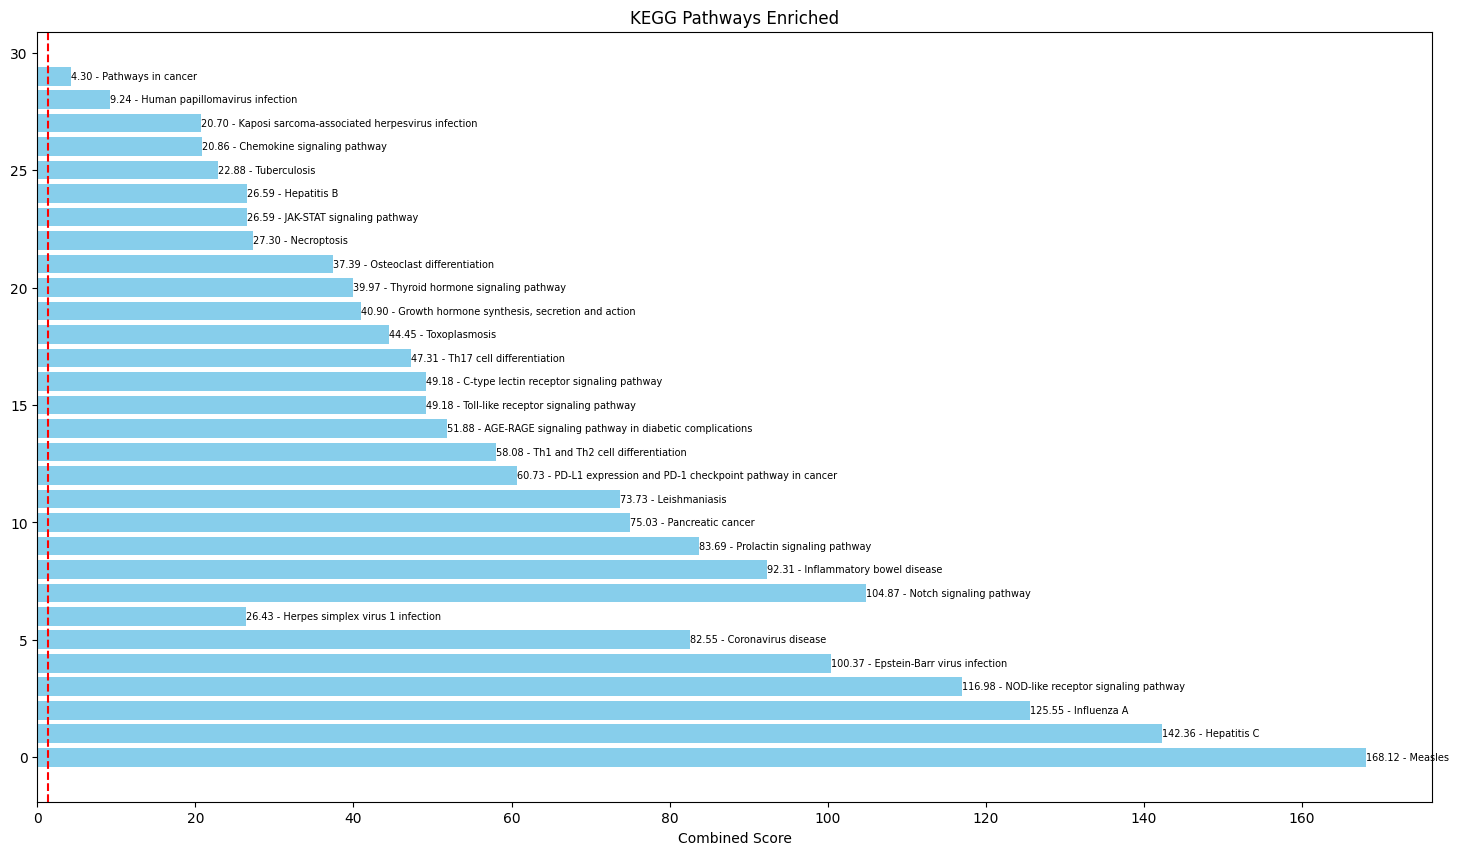

In [78]:
# Pretty print results
#print(enr_res.res2d.head())

# Plot results (do not use gp.gsea_plot, it is broken)
plt.figure(figsize=(18, 10))
plt.barh(enr_res.res2d.index, enr_res.res2d['Combined Score'], color='skyblue')
plt.xlabel('Combined Score')
plt.title('KEGG Pathways Enriched')

# Add significance threshold
plt.axvline(x=1.3, color='red', linestyle='--', label='p-value < 0.05')

# Add value in the Term column
for i, term in enumerate(enr_res.res2d.index):

    # Concatenate Combined Score and Term
    plt.text(enr_res.res2d['Combined Score'][i], i, f"{enr_res.res2d['Combined Score'][i]:.2f} - {enr_res.res2d['Term'][i]}", va='center', ha='left', fontsize=7)

plt.show()


In [ ]:
print(merged_df.head())

          126/126        127/126             128/126             129/126  \
Type           M1   M2        M1        M2        M1        M2        M1   
Accession                                                                  
A0AVT1        1.0  1.0  0.989894  0.936786  0.993734  1.027837  1.038208   
A0FGR8-2      1.0  1.0  0.814161  0.951382  0.797786  0.979001  0.827037   
A0JNW5        1.0  1.0  1.173734  1.045258  0.815727  1.068628  0.795561   
A0MZ66        1.0  1.0  1.042447  1.030733  1.021652  1.040322  1.057116   
A0T124        1.0  1.0  1.315904  0.999784  0.845168  0.846787  0.930313   

                      130/126             131/126           diff_abundance  
Type             M2        M1        M2        M1        M2                 
Accession                                                                   
A0AVT1     0.930783  1.155019  0.918391  1.062646  1.111090            0.0  
A0FGR8-2   0.907572  0.687835  0.763631  0.688810  0.739199            0.0  
A0JNW5

In [ ]:
print (merged_df.columns)
print(merged_df.index)


MultiIndex([(       '126/126', 'M1'),
            (       '126/126', 'M2'),
            (       '127/126', 'M1'),
            (       '127/126', 'M2'),
            (       '128/126', 'M1'),
            (       '128/126', 'M2'),
            (       '129/126', 'M1'),
            (       '129/126', 'M2'),
            (       '130/126', 'M1'),
            (       '130/126', 'M2'),
            (       '131/126', 'M1'),
            (       '131/126', 'M2'),
            ('diff_abundance',   '')],
           names=[None, 'Type'])
Index(['A0AVT1', 'A0FGR8-2', 'A0JNW5', 'A0MZ66', 'A0T124', 'A1A4S6', 'A1L0T0',
       'A1X283', 'A2A2W8', 'A3KN83-3',
       ...
       'Q9Y6G9', 'Q9Y6H1', 'Q9Y6I9', 'Q9Y6M1-1', 'Q9Y6M5', 'Q9Y6N5', 'Q9Y6W3',
       'Q9Y6W5-2', 'Q9Y6X5', 'Q9Y6X9-2'],
      dtype='object', name='Accession', length=3470)


In [ ]:
idx = pd.IndexSlice  # Shorthand for readability

# Function to perform paired t-test for each time point
def perform_ttest(df):
    p_values = []
    df = df.T
    for time_point in df.index.get_level_values(0).unique():  # Unique time points
        try:
            m1_values = df.loc[:, idx[time_point, 'M1']]
            m2_values = df.loc[:, idx[time_point, 'M2']]
            # Perform paired t-test and append p-value
            p_value = stats.ttest_rel(m1_values, m2_values).pvalue
            p_values.append(p_value)
        except KeyError as e:
            print(f"KeyError: {e} at time_point: {time_point}")
    return p_values

# Apply the function to each row
merged_df['p_value'] = perform_ttest(merged_df)

# Adjust p-values for multiple testing
merged_df['adjusted_p_value'] = multipletests(merged_df['p_value'], alpha=0.05, method='bonferroni')[1]

# Filter for significant differences
significant_proteins = merged_df[merged_df['adjusted_p_value'] < 0.05]


KeyError: "None of [Index(['126/126', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: 126/126
KeyError: "None of [Index(['127/126', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: 127/126
KeyError: "None of [Index(['128/126', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: 128/126
KeyError: "None of [Index(['129/126', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: 129/126
KeyError: "None of [Index(['130/126', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: 130/126
KeyError: "None of [Index(['131/126', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: 131/126
KeyError: "None of [Index(['diff_abundance', 'M1'], dtype='object', name='Accession')] are in the [columns]" at time_point: diff_abundance


ValueError: Length of values (0) does not match length of index (3470)

In [ ]:
# Function to perform paired t-test for each time point
def perform_ttest(df):
    p_values = []
    for time_point in df.index:
        print(time_point)
        print(df.loc[time_point, 'M2'], "A0AVT1")
        """
        print(df.loc[time_point, 'M2'])
        p_value = stats.ttest_rel(df.loc[time_point, 'M1'], df.loc[time_point, 'M2']).pvalue
        p_values.append(p_value)
        """
        return p_values

# Apply the function to each protein
merged_df['p_value'] = merged_df.apply(perform_ttest, axis=1)

# Adjust p-values for multiple testing (e.g., Bonferroni correction)
merged_df['adjusted_p_value'] = multipletests(merged_df['p_value'], alpha=0.05, method='bonferroni')[1]

# Filter for significant differences
significant_proteins = merged_df[merged_df['adjusted_p_value'] < 0.05]

In [ ]:
# Convert all cols to numeric
cols = ["126/126 Count", "127/126 Count", "128/126 Count", "129/126 Count", "130/126 Count", "131/126 Count"]
cols = ["126/126 Variability [%]", "127/126 Variability [%]", "128/126 Variability [%]", "129/126 Variability [%]", "130/126 Variability [%]", "131/126 Variability [%]"]

dataM0[cols] = dataM0[cols].apply(pd.to_numeric, errors='coerce')
dataM1[cols] = dataM1[cols].apply(pd.to_numeric, errors='coerce')
dataM2[cols] = dataM2[cols].apply(pd.to_numeric, errors='coerce')



In [ ]:
# Calculate relative abundance for dataM1 and dataM2

# Sum the total counts for each time point
total_counts_M1 = dataM1[["126/126 Count", "127/126 Count", "128/126 Count", "129/126 Count", "130/126 Count", "131/126 Count"]].sum()
total_counts_M2 = dataM2[["126/126 Count", "127/126 Count", "128/126 Count", "129/126 Count", "130/126 Count", "131/126 Count"]].sum()

# Divide each protein's count by the total counts for each time point
relative_abundance_M1 = dataM1[["126/126 Count", "127/126 Count", "128/126 Count", "129/126 Count", "130/126 Count", "131/126 Count"]].div(total_counts_M1)
relative_abundance_M2 = dataM2[["126/126 Count", "127/126 Count", "128/126 Count", "129/126 Count", "130/126 Count", "131/126 Count"]].div(total_counts_M2)

# Display the relative abundance data frames
print("Relative Abundance for dataM1:")
print(relative_abundance_M1)

print("\nRelative Abundance for dataM2:")
print(relative_abundance_M2)

In [ ]:
time_points = ["126/126 Variability [%]", "127/126 Variability [%]", "128/126 Variability [%]", "129/126 Variability [%]", "130/126 Variability [%]", "131/126 Variability [%]"]

# Compute the relative abundance for each time point
dataM1[time_points] = dataM1[time_points].div(total_counts_M1, axis=1)
dataM2[time_points] = dataM2[time_points].div(total_counts_M2, axis=1)

# Plot the relative abundance for each time point
dataM1[time_points].plot(kind='line')
plt.title("Relative Abundance for M1")
plt.show()


In [ ]:

time_points = ["126/126 Variability [%]", "127/126 Variability [%]", "128/126 Variability [%]", "129/126 Variability [%]", "130/126 Variability [%]", "131/126 Variability [%]"]

plt.figure(figsize=(12, 8))

# Plot each protein in dataM1 with red lines
for index, row in dataM1.iterrows():
    # Handle zeros to avoid log10(0) error
    values = row[time_points]
    values = [np.log10(v) if v > 0 else np.nan for v in values]
    plt.plot(time_points, values, color='red', alpha=0.5, label='M1' if index == 0 else "")

# Plot each protein in dataM2 with blue lines
for index, row in dataM2.iterrows():
    # Handle zeros to avoid log10(0) error
    values = row[time_points]
    values = [np.log10(v) if v > 0 else np.nan for v in values]
    plt.plot(time_points, values, color='blue', alpha=0.5, label='M2' if index == 0 else "")


# Add labels and title
plt.xlabel("Time Points")
plt.ylabel("Counts")
plt.title("Protein Counts over Time for M1 and M2")

# Display a legend for M1 and M2 groups
plt.legend()
plt.show()



In [ ]:
# same plot but now with log10 of relative abundance
plt.figure(figsize=(12, 8))

# Plot each protein in dataM1 with red lines
for index, row in relative_abundance_M1.iterrows():
    plt.plot(time_points, np.log10(row[time_points]), color='red', alpha=0.5, label='M1' if index == 0 else "")

# Plot each protein in dataM2 with blue lines
for index, row in relative_abundance_M2.iterrows():
    plt.plot(time_points, np.log10(row[time_points]), color='blue', alpha=0.5, label='M2' if index == 0 else "")

# Add labels and title
plt.xlabel("Time Points")
plt.ylabel("Log10 Relative Abundance")
plt.title("Protein Relative Abundance over Time for M1 and M2")

# Display a legend for M1 and M2 groups
plt.legend()
plt.show()


In [ ]:
for col in cols:
    plt.figure()
    #plt.plot(dataM0[col], label="M0 (-)")
    plt.plot(dataM1[col], label="M1 (IFN-γ)")
    plt.plot(dataM2[col], label="M2 (IL-4)")
    plt.title(col)
    plt.legend()
    plt.show()

---

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot violin plot for M1
sns.violinplot(data=dataM1.select_dtypes(include=[np.number]), ax=axs[0])
axs[0].set_title("M1")
axs[0].set_xlabel("Variables")
axs[0].set_ylabel("Values")

# Plot violin plot for M2
sns.violinplot(data=dataM2.select_dtypes(include=[np.number]), ax=axs[1])
axs[1].set_title("M2")
axs[1].set_xlabel("Variables")
axs[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

In [ ]:
# Describe the data
print("M1")
print(dataM1.describe())

print("M2")
print(dataM2.describe())

In [ ]:

# M1
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 7)
fig.suptitle('M1')
sns.boxplot(y=dataM1["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM1["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM1["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM1["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM1["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM1["# PSMs"], ax=axs[1, 2])
plt.tight_layout()
plt.show()

# M2
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 7)
fig.suptitle('M2')
sns.boxplot(y=dataM2["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM2["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM2["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM2["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM2["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM2["# PSMs"], ax=axs[1, 2])
plt.tight_layout()
plt.show()

In [ ]:
PEPTIDE_THRESHOLD = 2

# Print the number of proteins with less than PEPTIDE_THRESHOLD peptides
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M1: {dataM1[dataM1['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M2: {dataM2[dataM2['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")

# Filter out data with less than 2 peptides
dataM1 = dataM1[dataM1["# Peptides"] >= PEPTIDE_THRESHOLD]
dataM2 = dataM2[dataM2["# Peptides"] >= PEPTIDE_THRESHOLD]

In [ ]:
# Bottom limit for SCORE in percentage
SCORE_PCT_THRESHOLD = 25

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1
sns.histplot(dataM1['Score'], bins=50, log_scale=True, ax=axs[0])
m1_score_threshold = np.percentile(dataM1['Score'], SCORE_PCT_THRESHOLD)
axs[0].set_title("Distribution of scores (M1)")
axs[0].set_xlabel("Score")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_score_threshold, color='red')

# Plot dataM2
sns.histplot(dataM2['Score'], bins=50, log_scale=True, ax=axs[1])
m2_score_threshold = np.percentile(dataM2['Score'], SCORE_PCT_THRESHOLD)
axs[1].set_title("Distribution of scores (M2)")
axs[1].set_xlabel("Score")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_score_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['Score'] >= m1_score_threshold].shape[0]
print(f"%Proteins (Score >= {m1_score_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['Score'] >= m2_score_threshold].shape[0]
print(f"%Proteins (Score >= {m2_score_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")


In [ ]:
# Bottom limit for # PSMs in percentage
PSM_PCT_THRESHOLD = 10

# Plot the distribution of scores and # PSMs for both dataM1 and dataM2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1 # PSMs
sns.histplot(dataM1['# PSMs'], bins=50, log_scale=True, ax=axs[0])
m1_psm_threshold = np.percentile(dataM1['# PSMs'], PSM_PCT_THRESHOLD)
axs[0].set_title("Distribution of # PSMs (M1)")
axs[0].set_xlabel("# PSMs")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_psm_threshold, color='red')

# Plot dataM2 # PSMs
sns.histplot(dataM2['# PSMs'], bins=50, log_scale=True, ax=axs[1])
m2_psm_threshold = np.percentile(dataM2['# PSMs'], PSM_PCT_THRESHOLD)
axs[1].set_title("Distribution of # PSMs (M2)")
axs[1].set_xlabel("# PSMs")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_psm_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold for both dataM1 and dataM2
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['# PSMs'] >= m1_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m1_psm_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['# PSMs'] >= m2_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m2_psm_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")




In [ ]:

# Example dataset (replace with your data)
data = dataM1.drop(columns=['Description'])

# Compute pairwise correlations
correlations = data.corr().abs()  # Absolute correlation to avoid negative values

# Create a custom gradient from red to green
cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"])

# Function to get color based on correlation value
def get_color(value, cmap):
    norm_value = (value - correlations.min().min()) / (correlations.max().max() - correlations.min().min())
    return cmap(norm_value)

# do the same, but now using grey color for the diagonal
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10, 'alpha':0.1, 'edgecolor': None}, diag_kws={'color':'grey'})  # 's' controls dot size

# Loop through the axes to color each scatter plot
for i, j in zip(*np.triu_indices_from(correlations, 1)):
    ax = g.axes[i, j]
    corr_value = correlations.iloc[i, j]
    color = get_color(corr_value, cmap)
    
    # Apply the color gradient to all scatter plot
    ax.collections[0].set_facecolor(color)
    ax = g.axes[j, i]
    ax.collections[0].set_facecolor(color)


plt.show()




In [ ]:


# Define pairs of features to plot
features_to_plot = [
    ('# PSMs', '# Peptides'),
    ('# PSMs', '# Unique Peptides'),
    ('# Peptides', '# Unique Peptides'),
    ('Coverage', 'Score'),
    ('Score', '# PSMs'), 
    ('# Proteins', '# Unique Peptides')
]

# Set grid dimensions (adjust as needed)
rows, cols = 2, 2  # Create a 2x2 grid
rows, cols = features_to_plot.__len__() // 2, 2

# Configure plot size and style outside the loop (efficiency)
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Set figure size and create axes grid
point_size = 20
alpha = 0.2
marker = 'o'
color = 'blue'
grid_params = {'linestyle': '--', 'linewidth': 0.5, 'color': 'gray', 'which': 'both', 'alpha': 0.5}



# Loop through features and create plots
for i in range(rows):
    for j in range(cols):
        x_feature, y_feature = features_to_plot[i * cols + j]  # Access feature pair

        # Create the scatter plot on the current axis
        axes[i, j].scatter(dataM1[x_feature], dataM1[y_feature], s=point_size, alpha=alpha, marker=marker, c=color)

        # Set axis labels and title
        axes[i, j].set_xlabel(x_feature, fontsize=10)
        axes[i, j].set_ylabel(y_feature, fontsize=10)
        axes[i, j].set_title(f'{x_feature} vs. {y_feature}', fontsize=12)

        # Add grid lines
        axes[i, j].grid(**grid_params)

# Adjust spacing and display the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()

### Consider only those proteins with **Score** above the Threshold 

In [ ]:
dataM1 = dataM1[dataM1['Score'] >= m1_score_threshold]
dataM2 = dataM2[dataM2['Score'] >= m2_score_threshold]

### List the 100 most present proteins in both M1 and M2  *(do not work for identyfing the cell type)*
As "present" I consider those that appear more frequent in the spectra (based on PSMs)

In [ ]:
TOP_NUMBER = 100

# Take the top proteins based on the PSMs value (sorted in descending order)
topM1 = dataM1.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)
topM2 = dataM2.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)


In [ ]:
plt.figure(figsize=(9, 9))

# Filter the proteins present in both topM1 and topM2
common_top_proteins = topM1.index.intersection(topM2.index)
print(f"Number of common proteins: {len(common_top_proteins)}")

# Create a mask to filter the common proteins
mask_common = dataM1.index.isin(common_top_proteins)

# plot
plt.scatter(topM1.loc[common_top_proteins]['Score'], topM2.loc[common_top_proteins]['Score'])
plt.xlabel('Score (M1)')
plt.ylabel('Score (M2)')
plt.title('Score (M1) vs Score (M2) for common proteins')
# Add the names of the proteins in small font
for protein in common_top_proteins:
    # add a separation between the dot and the text
    separation = 0.1
    plt.text(topM1.loc[protein]['Score']+separation, topM2.loc[protein]['Score'], protein, fontsize=6)

# Diagonal line
max_value = max(topM1['Score'].max(), topM2['Score'].max())
plt.plot([0, max_value], [0, max_value], color='red')

plt.show()




In [ ]:
# Print a table with the first 10 proteins of common_top_proteins. The table must contain the Accession, Description, ScoreM1, ScoreM2, #PSMs M1, #PSMs M2, #Peptides M1, #Peptides M2, #Unique Peptides M1, #Unique Peptides M2, Coverage M1, Coverage M2
print("Table with the first 10 proteins of common_top_proteins")

# Create a table with the first 10 proteins of common_top_proteins
table = pd.DataFrame(index=common_top_proteins[:10])
table['Description'] = dataM1.loc[common_top_proteins[:10]]['Description']
table['Score M1'] = dataM1.loc[common_top_proteins[:10]]['Score']
table['Score M2'] = dataM2.loc[common_top_proteins[:10]]['Score']
table['# PSMs M1'] = dataM1.loc[common_top_proteins[:10]]['# PSMs']
table['# PSMs M2'] = dataM2.loc[common_top_proteins[:10]]['# PSMs']
table['# Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Peptides']
table['# Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Peptides']
table['# Unique Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Unique Peptides']
table['# Unique Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Unique Peptides']
table['Coverage M1'] = dataM1.loc[common_top_proteins[:10]]['Coverage']
table['Coverage M2'] = dataM2.loc[common_top_proteins[:10]]['Coverage']

print(table)



### Differential Expression Analysis

In [ ]:
# Get the number of proteins in each dataset
n_proteins_M1 = len(dataM1)
n_proteins_M2 = len(dataM2)

# Get the number of proteins in common
common_proteins = dataM1.index.intersection(dataM2.index)
n_common_proteins = len(common_proteins)

# Create the Venn diagram plot
c = venn2(subsets=(n_proteins_M1 - n_common_proteins, n_proteins_M2 - n_common_proteins, n_common_proteins),
    set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)

# Add a title to the plot
plt.title('Proteins found in M1 and M2')

# Display the plot
plt.show()




In [ ]:

# Check the number of NaN values in dataM1 and dataM2
print("Number of NaN values in dataM1")
print(dataM1.isnull().sum())
print("Number of NaN values in dataM2")
print(dataM2.isnull().sum())

# Create a copy by mergin dataM1 and dataM2 keeping the proteins present in only one of the datasets
merged_data = pd.merge(dataM1, dataM2, how='outer', on='Accession', suffixes=('_M1', '_M2'))
merged_data_original = merged_data.copy()
print(merged_data.isnull().sum())

merged_data['Description_M2'] = merged_data['Description_M2'].fillna('N/A')
merged_data['Description_M1'] = merged_data['Description_M1'].fillna('N/A')

# Replace missing values (NaN) with a very small value
merged_data.fillna(1e-1000, inplace=True)
print(merged_data.isnull().sum())

# Log fold change with the adjusted value
merged_data['Log2FC'] = np.log2(merged_data['# PSMs_M2'] + 1) - np.log2(merged_data['# PSMs_M1'] + 1)



As we can observe, there is no missing value in the original dataset.

In [ ]:
print(f"Number of 'N/A' in Description_M1: {merged_data[merged_data['Description_M1'] == 'N/A'].shape[0]}")
print(f"Number of 'N/A' in Description_M2: {merged_data[merged_data['Description_M2'] == 'N/A'].shape[0]}")

print(f"Number of proteins that are present in both datasets: {merged_data_original[merged_data_original['Description_M1'].notnull() & merged_data_original['Description_M2'].notnull()].shape[0]}")


In [ ]:
# Add a 'class' column to the merged_data. 
merged_data['class'] = "Both"
merged_data.loc[(merged_data['Description_M1'] != 'N/A') & (merged_data['Description_M2'] == 'N/A'), 'class'] = "M1"
merged_data.loc[(merged_data['Description_M1'] == 'N/A') & (merged_data['Description_M2'] != 'N/A'), 'class'] = "M2"
print(merged_data['class'].value_counts())           



In [ ]:
# Distribution of the log fold change for the class "Booth"
plt.figure(figsize=(10, 6))
sns.histplot(merged_data[merged_data['class'] == 'Both']['Log2FC'], bins=50, kde=True)
plt.title("Log2FC distribution for proteins present in both conditions")
plt.xlabel("Log2FC")
plt.ylabel("Frequency")
plt.show()   



Positive values in the 'Log2FC' column represent proteins that are more abundant in condition M2 compared to M1.<br>
Negative Log2FC values indicate proteins that are more abundant in condition M1 compared to M2.<br><br>
*Note that it was computed using #PSMs.*

In [ ]:
# Top 10 proteins with the highest log fold change
top10 = merged_data.sort_values(by='Log2FC', ascending=False).head(10)
print(top10[['Description_M1', 'Description_M2', 'Log2FC']])


In [ ]:
# describe merged_data
print(merged_data.describe())

In [ ]:
# Create the PCA object
pca = PCA(n_components=2)

# Create the StandardScaler object
scaler = StandardScaler()

# Fit the scaler
scaler.fit(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Transform the data
X = scaler.transform(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Fit the PCA
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Create a dataframe with the PCA values
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Add the class column
pca_df['class'] = merged_data['class'].values

# Plot the PCA
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class')
plt.title('PCA of the merged data')
plt.show()


In [ ]:
# Create the UMAP object
umap_obj = umap.UMAP()

# Fit the UMAP
umap_obj.fit(X)

# Transform the data
X_umap = umap_obj.transform(X)

# Create a dataframe with the UMAP values
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

# Add the class column
umap_df['class'] = merged_data['class'].values

# Plot the UMAP
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='class')
plt.title('UMAP of the merged data')
plt.show()


In [ ]:
# Initialize a list to store p-values
p_values = []

# Loop through each protein to calculate the p-value using Fisher's exact test
for index, row in merged_data.iterrows():
    # Create a 2x2 contingency table based on presence/absence in M1 and M2
    # Assumes 1 for present, 0 for absent
    if row['class'] == 'M1' or row['class'] == 'M2':
        present_m1 = 1 if row['class'] == 'M1' else 0
        present_m2 = 1 if row['class'] == 'M2' else 0

        # Contingency table format: [[present in M1, absent in M1], [present in M2, absent in M2]]
        contingency_table = [[present_m1, 1 - present_m1], [present_m2, 1 - present_m2]]
        
        # Perform Fisher's Exact Test
        _, p_val = fisher_exact(contingency_table)
        p_values.append(p_val)
    else:
        # If the protein is present in both or absent in both, assign a default p-value (e.g., 1)
        p_values.append(1.0)

# Add p-values to the dataframe
merged_data['p_value_class'] = p_values

# print unique p-values
print(f"Unique p-values (class): {len(set(p_values))}")



As **all p-values are 1**, it means that there is no significant difference between the two groups for any protein.
This make sense considering the chart with the PSM's (M1) vs PSM's (M2) 

---
# DEA
Identify proteins that are significantly upregulated or downregulated between different conditions (M1 vs M2).

In [ ]:
data = merged_data.copy()
# drop p_value_class
data = data.drop(columns=['p_value_class'])
print(data.describe())

In [ ]:
# Create a "data" dataframe with the columns 'Accession', '# PSMs_M1' and '# PSMs_M2'
data = merged_data[merged_data['class'] == 'Both'][['# PSMs_M1', '# PSMs_M2']]

# Melt the DataFrame into long format
df_long = data.stack().reset_index()
df_long.columns = ['Protein', 'Condition', 'PSM']

# Extract the condition from the column name
df_long['Condition'] = df_long['Condition'].str.extract(r'# PSMs_(M\d+)')

print(df_long)

In [ ]:
# Convert it to wide format
df_wide = df_long.pivot(index='Protein', columns='Condition', values='PSM')
print(df_wide)

In [ ]:
# Assuming your DataFrame is named 'df'
data_matrix = data.values.T  # Transpose to get a matrix-like structure

# Create an AnnData object
adata = ad.AnnData(
    X=data_matrix,
    obs=pd.DataFrame({'Condition': ['M1', 'M2']}),
    var=pd.DataFrame(index=data.index)
)

In [ ]:
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
print(adata.obs['Condition'].dtype)
print(adata.obs['Condition'])

# DEA with scanpy
sc.tl.rank_genes_groups(adata, groupby='Condition', method='wilcoxon')

# Draw a Volcano plot
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Display the plot
plt.show()






In [ ]:
# Compute the log fold change and p-value for each protein in a new DataFrame
df_lfc = pd.DataFrame()
df_lfc['Protein'] = df_long['Protein'].unique()
df_lfc['Log2FC'] = np.log2(df_long[df_long['Condition'] == 'M2']['PSM'].values + 1) - np.log2(df_long[df_long['Condition'] == 'M1']['PSM'].values + 1)
print(df_lfc.head(20))


In [ ]:
# Convert the dataframe into a wide format
df_wide = df_long.pivot(index='Protein', columns='Condition', values='PSM')
df_wide.columns = ['M1', 'M2']
print(df_wide)


In [ ]:
data = merged_data[merged_data['class'] == 'Both'].copy()
# move the indexes to rows
data = data.reset_index()
# move the indexes to columns


print(data.head())
print("---")
data= data.reset_index()
print(data.head())
print("---")
# Filter out the p-value column
data = data.drop(columns=['p_value_class'])
#data = data.drop(columns=['class'])
data = data.drop(columns=['Description_M1'])
data = data.drop(columns=['Description_M2'])


# If Log2FC is < 0, the protein is downregulated in M2 and set class to "M2"
data.loc[data['Log2FC'] < 0, 'class'] = 2
# If Log2FC is > 0, the protein is upregulated in M2 and set class to "M1"
data.loc[data['Log2FC'] > 0, 'class'] = 1
# Delete rows with Log2FC = 0
data = data[data['Log2FC'] != 0]




# Perform a differential expression analysis with the proteins of data that contantains proteins found under M1 & M2, with the Log2FC already computed
# Create an AnnData object with all the values to the object except the class column. Exclude also the index that contains the Accession
adata = ad.AnnData(data.drop(columns=['Log2FC']).T)
print(adata)
print(adata.obs)


# Reset the index if necessary
if adata.obs.index.name == 'class':
    adata=adata.obs.reset_index(inplace=True)

print(adata)
print(adata.obs)


# Assuming 'adata' is your AnnData object
adata.obs['class'] = adata.obs['class'].astype('category')  # Convert to categorical

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.tl.rank_genes_groups(adata, 'class', method='wilcoxon')

sc.pl.umap(adata, color='class')
sc.pl.violin(adata, 'gene_name', group='class')

In [ ]:
data = merged_data[merged_data['class'] == 'Both'].copy()

# Filter out the p-value column
data = data.drop(columns=['p_value_class'])
#data = data.drop(columns=['class'])
data = data.drop(columns=['Description_M1'])
data = data.drop(columns=['Description_M2'])


# If Log2FC is < 0, the protein is downregulated in M2 and set class to "M2"
data.loc[data['Log2FC'] < 0, 'class'] = 2
# If Log2FC is > 0, the protein is upregulated in M2 and set class to "M1"
data.loc[data['Log2FC'] > 0, 'class'] = 1
# Delete rows with Log2FC = 0
data = data[data['Log2FC'] != 0]

print(data['class'].value_counts())

# Perform a differential expression analysis with the proteins of data that contantains proteins found under M1 & M2, with the Log2FC already computed
# Create an AnnData object with all the values to the object except the class column. Exclude also the index that contains the Accession
adata = ad.AnnData(data.drop(columns=['class', 'Log2FC']))
# Add the class column to the object
#adata.obs['Accession'] = data.index
# Create an obs called 'class' with the values of the class column with 'M' as prefix
#adata.obs['class'] = 'M' + data['class'].astype(str)
adata.obs['class'] = data['class'].astype(str)


print(adata)
# print the name of the n_vars
print(adata.var_names)



# Perform PCA
#sc.tl.pca(adata)
# Plot the PCA
#sc.pl.pca(adata, color='class')

# Perform UMAP
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

# Plot the UMAP
#sc.pl.umap(adata, color='class')




# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='class', method='wilcoxon')

# Create a dataframe with the results
results = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
results['logfoldchanges'] = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
results['pvals'] = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
results['pvals_adj'] = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])

# Print the results
print(results.head())


# Create a volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='logfoldchanges', y='pvals_adj')
plt.title('Volcano plot')
plt.xlabel('Log2FC')
plt.ylabel('Adjusted p-value')
plt.show()




---
# Functional Enrichement Analysis
Determine the biological functions and pathways that are overrepresented among differentially expressed proteins.<br>
This can provide insights into the broader biological context of the observed changes and identify potential drug targets or biomarkers.

In [ ]:
# Take the 10 most abundant proteins in M1 and M2 and create a Venn diagram
# Get the top 10 proteins in M1 and M2
top10_M1 = dataM1.sort_values(by='# PSMs', ascending=False).head(10).index
top10_M2 = dataM2.sort_values(by='# PSMs', ascending=False).head(10).index

# Create the Venn diagram
plt.figure(figsize=(6, 6))
c = venn2(subsets=(set(top10_M1), set(top10_M2)), set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)
plt.title('Top 10 proteins in M1 and M2')
plt.show()


In [ ]:
# Get gene names
unipcl = UniprotClient()

gene_names = unipcl.batch_translate_protein_ids(top10_M1.tolist())
top10_M1.index = [gene_names.get(i, i) for i in top10_M1.tolist()]

In [ ]:
sdb = StringDBClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

In [ ]:
# Get the network of the top 10 proteins in M1
for protein in top10_M1.index:
    print("-" * 150)

    gene = protein.split(" (")[0]
    print("Gene: ", gene)
    print("Protein: ", protein.split("(")[1].split(")")[0])
    
    if (gene != "None"):
        image_data = sdb.get_network_image(gene, "image")
        page = sdb.get_protein_page(gene, "tsv-no-header")
        print(page)
        display(Image(image_data))
    else:
        print("No gene found in Uniprot for protein ", protein, ". It might be an obsolete protein.")
        print(" ")

In [ ]:
# Functional Enrinchment analysis with GO terms
top10_M1 = dataM1.sort_values(by='# PSMs', ascending=False).head(20).index
top10_M2 = dataM2.sort_values(by='# PSMs', ascending=False).head(20).index



# Get the gene names
gene_names_M1 = unipcl.batch_translate_protein_ids(top10_M1.tolist())
#gene_names_M2 = unipcl.batch_translate_protein_ids(top10_M2.tolist())
print(gene_names_M1)
# prepare a list of gene names. The gene name corresponds to the value before the first parenthesis
gene_names_M1 = [gene.split(" (")[0] for gene in gene_names_M1.values()]
#gene_names_M2 = [gene.split(" (")[0] for gene in gene_names_M2]

print(gene_names_M1)




# Remove the None values
gene_names_M1 = [gene for gene in gene_names_M1 if gene != "None"]



In [ ]:
print(gene_names_M1)

# Get the GO terms for the top 10 proteins in M1 and M2
# Perform enrichment analysis
enr_res = gp.enrichr(gene_names_M1, gene_sets='KEGG_Pathway', organism='human')

# Visualize the results
gp.dotplot(enr_res)

In [ ]:

# Define thresholds
logFC_threshold = 1  # Threshold for log fold change (absolute value)
pval_threshold = 0.05  # Threshold for p-value

# Create a new column to categorize proteins based on thresholds
merged_data['significant'] = (merged_data['adjusted_p_value'] < pval_threshold) & (abs(merged_data['logFC_Proteins']) > logFC_threshold)

# Create volcano plot
plt.figure(figsize=(10, 7))

# Scatter plot for non-significant points (grey)
plt.scatter(merged_data['logFC_Proteins'], -np.log10(merged_data['adjusted_p_value']), c='grey', label='Non-significant')

# Highlight significant points (red for upregulated, blue for downregulated)
plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='red', label='Upregulated')

plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='blue', label='Downregulated')

# Add labels
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot')

# Show legend
plt.legend()

# Show plot
plt.show()


---

# Protein-Protein Interaction Network Analysis
Construct networks to visualize the interactions between proteins and identify protein modules or hubs.<br>
This can help understand how proteins work together to carry out cellular functions and identify key regulatory proteins

---


In [ ]:
# Join the dataM1 and dataM2 dataframes adding a column to identify the source of the data
dataM1['Source'] = 'M1'
dataM2['Source'] = 'M2'

# Concatenate the dataframes
data = pd.concat([dataM1, dataM2])

# Number of proteins in the concatenated dataframe
print(f"Number of proteins in the concatenated dataframe: {data.shape[0]}")

In [ ]:
# Perform a differential expression analysis without using scanpy

# Filter the proteins with a score higher than the threshold
data_filtered = data

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Perform a differential expression analysis
# Create a new column with the log2 fold change
data_filtered['log2FC'] = np.log2(data_filtered['# PSMs']/data_filtered['# PSMs'].mean())

# Create a new column with the p-value
data_filtered['p-value'] = 1 - data_filtered['Score']/data_filtered['Score'].max()

# Create a new column with the adjusted p-value
data_filtered['adj-p-value'] = data_filtered['p-value']

# Filter the proteins with an adjusted p-value lower than 0.05
data_filtered = data_filtered[data_filtered['adj-p-value'] < 0.05]

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Print the first 10 proteins
print(data_filtered.head(10))

# Perform a differential expression analysis using scanpy

# Create an AnnData object
adata = ad.AnnData(data_filtered)

# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='Source', method='wilcoxon')

# Print the results
print(adata.uns['rank_genes_groups'])

# Perform a differential expression analysis using scanpy



In [ ]:
# Considering the TOP_NUMBER proteins in both M1 and M2, perform a differential expression analysis using the #PSMs as the feature to compare. Use the Wilcoxon test to compare the #PSMs of the proteins in M1 and M2. Plot the results in a volcano plot.
from scipy.stats import wilcoxon

# Perform the Wilcoxon test for each protein
p_values = []
for protein in common_proteins:
    p_values.append(wilcoxon(dataM1.loc[protein]['# PSMs'], dataM2.loc[protein]['# PSMs']).pvalue)

# Create a volcano plot
plt.figure(figsize=(12, 6))
plt.scatter(p_values, [0]*len(p_values), alpha=0.5)
plt.xlabel('p-value')
plt.ylabel('log2(fold-change)')
plt.title('Volcano plot')
plt.show()





              



In [ ]:
# Load the data
data_src = "./data/raw/sasha_SI_THP/SI_THP_RAW_proteomics_data_ss.xlsx"
dataM1 = pd.read_excel(data_src, sheet_name="THP_M1", index_col=0)
dataM2 = pd.read_excel(data_src, sheet_name="THP_M2", index_col=0)

# Concatenate the dataM1 and dataM2 vertically
data = pd.concat([dataM1, dataM2])

# Transpose the data
data = data.T

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

# Add the cell type information to the adata object
cell_types = ['M1'] * dataM1.shape[0] + ['M2'] * dataM2.shape[0]
adata.obs['celltype'] = cell_types

# Perform PCA analysis
sc.tl.pca(adata)

# Plot PCA
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


---

---

In [ ]:
# Load the data (Scanpy assumes that your columns are genes and your rows are cells)
data_src = "./data/spetch/proteins-processed.csv"
data = pd.read_csv(data_src, delimiter=",")

# Remove the last column
data = data.iloc[:, :-1]

# Transpose the data
data = data.T

# Keep the first row as the column names
proteins = data.iloc[0]

# Remove the first column
data = data.iloc[1:]

print(data)

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

proteins = proteins.to_numpy()
adata.var['proteins'] = proteins

print(adata)


In [ ]:
# Load the anno.csv file with the cell type annotations
anno_src = "./data/spetch/cells.csv"
anno = pd.read_csv(anno_src, delimiter=",")

# Get the column names as cell IDs
cellID = anno.columns[1:]

# Transpose the data
anno = anno.T

celltypes = anno.loc[:, 0].values

# Remove the first element
celltypes = celltypes[1:]

# Create a new obs in the AnnData object with the cell type annotations 
adata.obs['cellID'] = cellID
adata.obs['celltype'] = celltypes



In [ ]:
print(adata)
print("---")
print(adata.X)

---
### Convert Protein ID to Gene names

In [ ]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    gene_names = unipcl.batch_translate_protein_ids(adata.var['proteins'])
    adata.var['gene_protein'] = [gene_names.get(i, i) for i in adata.var['proteins']]
    adata.var['gene'] = [i.split(' ')[0] for i in adata.var['gene_protein']]
    print(adata.var['proteins'])
    print(adata.var['gene_protein'])
    print(adata.var['gene'])


In [ ]:
adata_back = adata.copy()

---
### PCA & UMAP



In [ ]:
# PCA by cell type
sc.tl.pca(adata)
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


In [ ]:
# UMAP by cell type
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype', size=60, title='UMAP by cell type')


---

In [ ]:
num_bins = 20

for celltype in adata.obs['celltype'].unique():
    plt.hist(adata[adata.obs['celltype'] == celltype].X.flatten(), bins=num_bins, alpha=0.5, label=celltype)

plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Protein Intensity distribution by Cell Type')

plt.legend()
plt.show()


In [ ]:

# Shift the matrix values so that all are positive
min_value = adata.X.min()
if min_value < 0:
    adata.X += np.abs(min_value) + 1  # Shift values to ensure they're all positive

# Filter to keep only the two groups you're interested in
group_1 = 'sc_m0'
group_2 = 'sc_u'

# Create a mask to filter the two groups
mask = adata.obs['celltype'].isin([group_1, group_2])
adata_filtered = adata[mask, :]

# Perform rank_genes_groups to find differentially expressed proteins between the two groups
sc.tl.rank_genes_groups(adata_filtered, 'celltype', groups=[group_1], reference=group_2, method='wilcoxon')

# Get log fold change and p-values
log2_fc = adata_filtered.uns['rank_genes_groups']['logfoldchanges'][group_1]  # Log2 fold changes
p_values = adata_filtered.uns['rank_genes_groups']['pvals'][group_1]          # p-values


# Convert p-values to -log10 for the volcano plot
log_p_values = -np.log10(p_values)

# Step 4: Create the volcano plot
volcano_data = pd.DataFrame({
    'log2_FC': log2_fc,
    '-log10_p_value': log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(volcano_data['log2_FC'], volcano_data['-log10_p_value'], s=5)

# Add vertical lines to mark fold change threshold
plt.axvline(x=1, color='black', linestyle='--')  # Fold change threshold
plt.axvline(x=-1, color='black', linestyle='--')  # Fold change threshold

# Add horizontal lines to mark significance (e.g., p-value threshold)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # p-value threshold

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-value')
plt.title(f'Volcano Plot: {group_1} vs {group_2}')

plt.show()


### Experiments


In [ ]:
# Assuming adata is your AnnData object containing the intensity matrix
adata.X += 10  # Add a constant to ensure non-negativity
adata.X = adata.X / adata.X.max() * 1000  # Scale to a maximum count of 1000

# Sample from Poisson distribution to simulate count data
adata.X = np.random.poisson(adata.X)

adata.X = np.log2(adata.X + 1)  # Add 1 to avoid log of zero

In [ ]:
# Differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.pl.rank_genes_groups(adata)

In [ ]:
print(result)

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
group1 = groups[0]
group2 = groups[1]

# Create DataFrame for easier handling
df = pd.DataFrame({
    'protein': result['names'][group1],
    f'logFC_{group1}': result['logfoldchanges'][group1],
    f'logFC_{group2}': result['logfoldchanges'][group2],
    f'pval_{group1}': result['pvals'][group1],
    f'pval_{group2}': result['pvals'][group2],
    f'pval_adj_{group1}': result['pvals_adj'][group1],
    f'pval_adj_{group2}': result['pvals_adj'][group2],
    f'score_{group1}': result['scores'][group1],
    f'score_{group2}': result['scores'][group2]
})

# Filter out entries with NaN log fold changes
df_filtered = df.dropna(subset=[f'logFC_{group1}', f'logFC_{group2}'])

# Print the filtered DataFrame
print(df_filtered.head())


In [ ]:

# Extract results for volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')


plt.show()

# Clustering and dendrogram
sc.tl.dendrogram(adata, groupby='celltype')
sc.pl.dendrogram(adata, groupby='celltype')

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()

In [ ]:
# Differential expression analysis with optional sparse matrix conversion
#sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata)

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

In [ ]:
# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()


In [ ]:
# Clustering
sc.tl.dendrogram(adata, groupby='celltype')

# Plot dendrogram
sc.pl.dendrogram(adata, groupby='celltype')
